
# Multiple Structural alignment of orthologous proteins

In this example we perform a structural alignment of multiple lysozyme
variants from different organisms.
A feasible approach to perfrom such a multiple structure alignment is the
usage of a structural alphabet:
At first the structure is translated into a sequence that represents
the structure.
Then the sequences can be aligned with the standard sequence alignment
techniques, using the substitution matrix of the structural alphabet.

In this example, the structural alphabet we will use is called
*Protein Blocks* (PBs) :footcite:`Brevern2000, Barnoud2017`:
There are 16 different PBs, represented by the symbols ``a`` to ``p``.
Each one depicts a different set of the backbone dihedral angles of a
peptide 5-mer.

.. footbibliography::


In [1]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

import matplotlib.pyplot as plt
import biotite.database.rcsb as rcsb
import biotite.sequence.align as align
import biotite.sequence.graphics as graphics
import biotite.structure as struc
import biotite.structure.alphabet as strucalph
import biotite.structure.io.pdbx as pdbx

In [2]:
PDB_IDS = ["1D3Z", "1U4A"]

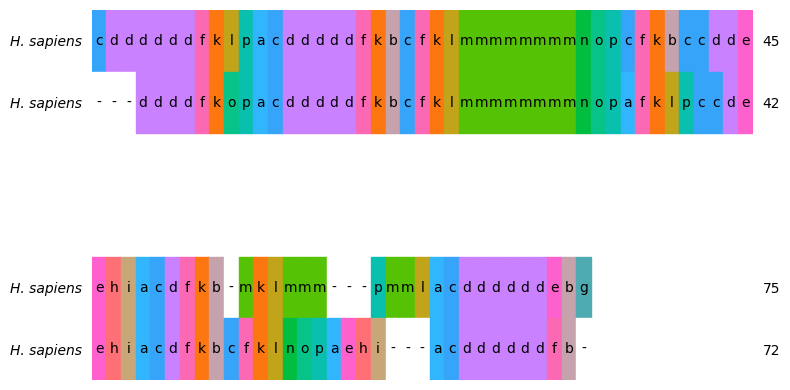

In [3]:
# Create a PB sequence from each structure
structural_sequences = []
organisms = []
for pdb_id in PDB_IDS:
    file = pdbx.BinaryCIFFile.read(rcsb.fetch(pdb_id, "bcif"))
    # Take only the first model into account
    array = pdbx.get_structure(file, model=1)
    # We are only interested in the first protein chain
    array = array[struc.filter_amino_acids(array)]
    array = array[array.chain_id == array.chain_id[0]]
    pb_sequences, _ = strucalph.to_protein_blocks(array)
    structural_sequences.append(pb_sequences[0].remove_undefined())

    try:
        organism_name = file.block["entity_src_nat"][
            "pdbx_organism_scientific"
        ].as_item()
    except KeyError:
        organism_name = file.block["entity_src_gen"][
            "pdbx_gene_src_scientific_name"
        ].as_item()
    generic, specific = organism_name.split(" ")
    abbreviation = f"{generic[0]}. {specific}"
    organisms.append(abbreviation)


# Perform a multiple sequence alignment of the PB sequences
matrix = align.SubstitutionMatrix.std_protein_blocks_matrix()
alignment, order, _, _ = align.align_multiple(
    structural_sequences, matrix, gap_penalty=(-500, -100), terminal_penalty=False
)

# Visualize the alignment
# Order alignment according to guide tree
alignment = alignment[:, order.tolist()]
labels = [organisms[i] for i in order]
fig = plt.figure(figsize=(8.0, 4.0))
ax = fig.add_subplot(111)
# The color scheme was generated with the 'Gecos' software
graphics.plot_alignment_type_based(
    ax,
    alignment,
    labels=labels,
    symbols_per_line=45,
    spacing=2,
    show_numbers=True,
    color_scheme="flower",
)
# Organism names in italic
ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontstyle": "italic"})
fig.tight_layout()
plt.show()